# Imports

In [9]:
# Libraries

# Data Analysis
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img

# Classes Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16

# Sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# others
import pandas as pd
import time
import numpy as np
import random
import os

from PIL import Image
import cv2
from IPython.display import display
from tqdm import tqdm_notebook
import copy # To copy later our best model

# Chargement des données

## Config

In [2]:
# Emplacement
path = "C:/Users/Nina/Documents/GitHub/AVR23---BDS---Radio-Pulm/data"     ### A MODIFIER EN LOCAL !!
dirs = ["Normal/images/","COVID/images/","Lung_Opacity/images/","Viral Pneumonia/images/"]
dirsm = ["Normal/masks/","COVID/masks/","Lung_Opacity/masks/","Viral Pneumonia/masks/"]
ID_DIR = 7

# Classes de 0 à 3 dans la suite
classes = ("Normal","COVID ","Lung_Opacity","Viral Pneumonia") 
nbClasses = len(classes)

# Paramètres
SIZE = (224,224)
RATIO_VAL = 0.2 
BATCH_SIZE = 42
NB_EPOCHS = 2
ECH_SIZE = 2000

## Dataframe

In [3]:
# Création des 4 listes de noms d'images
normal_imgs = [fn for fn in os.listdir(f'{path}/Normal/images') if fn.endswith('.png')]
covid_imgs = [fn for fn in os.listdir(f'{path}/COVID/images') if fn.endswith('.png')]
pneumonia_imgs = [fn for fn in os.listdir(f'{path}/Viral Pneumonia/images') if fn.endswith('.png')]
lung_opacity_imgs = [fn for fn in os.listdir(f'{path}/Lung_Opacity/images') if fn.endswith('.png')]

# Concaténation des emplacements de toutes les images dans une liste unique
liste_paths = []
for fn in normal_imgs :
    liste_paths.append(f'{path}/Normal/images/' + fn)
for fn in covid_imgs :
    liste_paths.append(f'{path}/COVID/images/' + fn)
for fn in pneumonia_imgs :
    liste_paths.append(f'{path}/Viral Pneumonia/images/' + fn)
for fn in lung_opacity_imgs :
    liste_paths.append(f'{path}/Lung_Opacity/images/' + fn)

# Découpage des noms de chaque emplacement et récupération de la classe (liste de listes)
liste_paths_classes = list(map(lambda x : [x, x.split('/')[ID_DIR]], liste_paths)) 
"""Le chiffre '6' est à changer en fonction de la longueur du path, le but est de recupérer les termes "nomrals", "covid",... """


# Création Dataframe des emplacements et classes images BRUTES
df = pd.DataFrame(liste_paths_classes, columns = ['filepath', 'nameLabel'])

# Remplacement des classes sous forme littérale par index
df['label'] = df['nameLabel'].replace(df.nameLabel.unique(), [*range(len(df.nameLabel.unique()))])
df = df.drop(['nameLabel'], axis=1)
df['label'] = df['label'].astype(str)

# Mélange du dataframe
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)

# Nettoyage variables inutiles
del liste_paths

df = df[0:ECH_SIZE]
df.head()

,filepath,label
0,C:/Users/Nina/Documents/GitHub/AVR23---BDS---R...,3
1,C:/Users/Nina/Documents/GitHub/AVR23---BDS---R...,1
2,C:/Users/Nina/Documents/GitHub/AVR23---BDS---R...,0
3,C:/Users/Nina/Documents/GitHub/AVR23---BDS---R...,2
4,C:/Users/Nina/Documents/GitHub/AVR23---BDS---R...,1


## Itérateur d'images

In [4]:
# Séparation dataframe en ensemble entraiement et validation
train, test = train_test_split(df, test_size=RATIO_VAL, shuffle = False)



# Création des itérateurs qui chargeront des lots d'images
train_data_generator = ImageDataGenerator( )
test_data_generator = ImageDataGenerator( )

# Initialisation du image generator de train
print(f"Number of rows in train set: {len(train)}")
train_generator = train_data_generator.flow_from_dataframe(dataframe = train,
                                                           x_col="filepath",
                                                           y_col="label",
                                                           class_mode = "sparse",
                                                           target_size = SIZE, #Resize
                                                           batch_size = BATCH_SIZE,) # En RGB !

# Initialisation du image generator de test
print(f"Number of rows in test set: {len(test)}")
test_generator = test_data_generator.flow_from_dataframe(dataframe = test,
                                                         x_col="filepath",
                                                         y_col="label",
                                                         class_mode = "sparse",
                                                         target_size = SIZE, #Resize
                                                         batch_size = BATCH_SIZE) # En RGB !

Number of rows in train set: 1600
Found 1600 validated image filenames belonging to 4 classes.
Number of rows in test set: 400
Found 400 validated image filenames belonging to 4 classes.


# Modèle

In [10]:
#Chargement et freeze modèle de base
base_model = VGG16(weights=None, include_top = False)
for layer in base_model.layers :
    layer.trainable = False

# Instanciation modèle séquentiel
vgg = Sequential()

# Ajout des différentes couches
vgg.add(base_model)
vgg.add(GlobalAveragePooling2D())
vgg.add(Dense(units = 1024, activation = "relu"))
vgg.add(Dropout(rate=0.2))
vgg.add(Dense(units = 512, activation = "relu"))
vgg.add(Dropout(rate=0.2))
vgg.add(Dense(units = 4, activation = "softmax"))

# Compilation
vgg.compile(loss = "sparse_categorical_crossentropy", optimizer = "Adam", metrics = ["accuracy"])

In [11]:
# Entrainement du modèle
train_size = train_generator.samples
test_size = test_generator.samples

history = vgg.fit(train_generator,
                              epochs = NB_EPOCHS,
                              steps_per_epoch = train_size // BATCH_SIZE,
                              validation_data = test_generator,
                              validation_steps = test_size // BATCH_SIZE)

Epoch 1/2
38/38 [==============================] - 796s 21s/step - loss: 1.2364 - accuracy: 0.4666 - val_loss: 1.1897 - val_accuracy: 0.5079
Epoch 2/2
38/38 [==============================] - 789s 21s/step - loss: 1.1826 - accuracy: 0.4897 - val_loss: 1.1714 - val_accuracy: 0.5106


# Evaluation

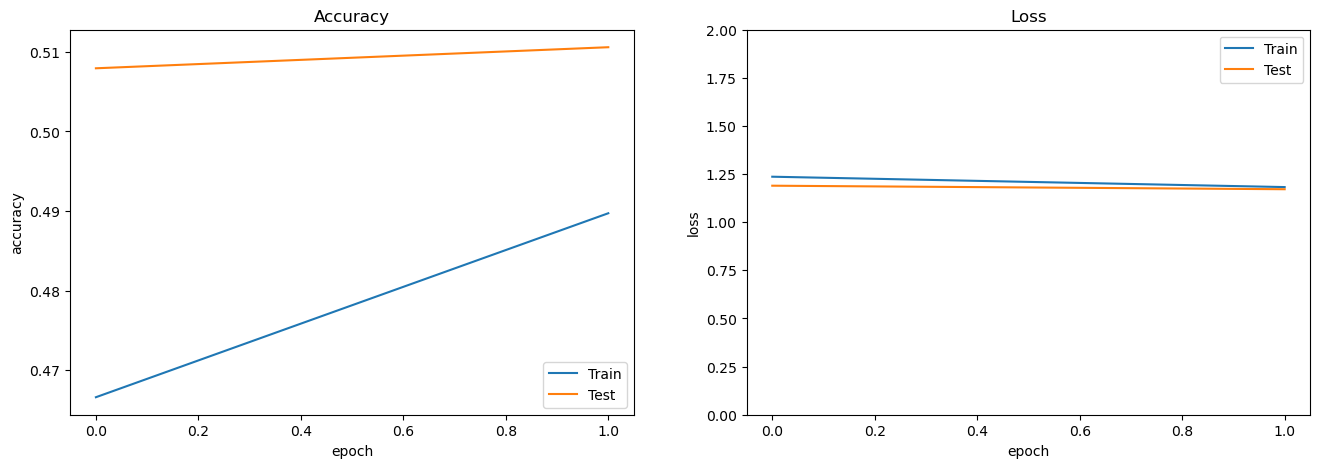

In [12]:
# Courbes d'accuracy et de perte
plt.figure(figsize = (16,5))

plt.subplot(121)
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy")

plt.subplot(122)
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(0,2)
plt.title("Loss")
plt.show();

In [17]:
# Calcul des prédictions (probabilités)
test_generator.reset()
test_pred = vgg.predict(test_generator, verbose = 1 )

10/10 [==============================] - 148s 14s/step


In [18]:
# Récupération des classes à partir des probabilités
test_pred_class = test_pred.argmax(axis = 1)

# Matrice de confusion
print(confusion_matrix(test["label"].astype("int"), test_pred_class)) ##Pb ICI ?

[[205   0   0   0]
 [ 66   0   0   0]
 [ 28   0   0   0]
 [101   0   0   0]]


In [19]:
print(classification_report(test["label"].astype("int"), test_pred_class)) ##Pb ICI ?

              precision    recall  f1-score   support

           0       0.51      1.00      0.68       205
           1       0.00      0.00      0.00        66
           2       0.00      0.00      0.00        28
           3       0.00      0.00      0.00       101

    accuracy                           0.51       400
   macro avg       0.13      0.25      0.17       400
weighted avg       0.26      0.51      0.35       400



c:\Users\Nina\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nina\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nina\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
